In [1]:
from itertools import chain
import torch
from torch import nn
from torchvision.datasets import CIFAR10
from torchvision import transforms as transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [23]:
# user modules
import sys
import os
from os import path
sys.path.append(path.dirname(path.abspath('')))
from models.wideresnet import WideResNet
from models.resnet import ResNet9, ResNet50
from metrics.similarity import *
from data.partition import partition_data, get_partition_dict
from data.datasets import load_cifar10_data
from data.dataloader import get_dataloader

In [4]:
def find_ckpt(expname, comm, modeldir='../ckpt', epoch=None, client=None):
    f = filter(lambda x: expname in x, os.listdir(modeldir))
    f = filter(lambda x: f'comm{comm:03}' in x, f)
    if client is None:
        f = filter(lambda x: f'GLOBAL' in x, f)
    else:
#         f = filter(lambda x: f'epoch{epoch:03}' in x, f)
        f = filter(lambda x: f'CLIENT{client:02}' in x, f)
    return list(f)[0]

In [5]:
def extract_repr(model, dataset, n_samples=256):
    reprs = []
    def hook(module, input_):
        reprs.append(input_)
    
    for module in chain(*[ch.modules() for ch in model.children()])
        module.register_forward_pre_hook(hook)
    
# only for resnet-9
#     model.layer1.register_forward_pre_hook(hook)
#     model.layer2.register_forward_pre_hook(hook)
#     model.layer3.register_forward_pre_hook(hook)
#     model.classifier.register_forward_pre_hook(hook)

    with torch.no_grad():
        model(torch.stack([data for data, target in dataset][:256]), )
    return [rep[0].view(rep[0].shape[0], -1) for rep in reprs]

SyntaxError: invalid syntax (2621874307.py, line 6)

In [10]:
def calc_sim(model_a, model_b):
    reprs_a= extract_repr(model_a, testset)
    reprs_b= extract_repr(model_b, testset)
    cka = np.zeros((len(reprs_a), len(reprs_b)))
    i=0
    for r_a in tqdm(reprs_a):
        j=0
        for r_b in tqdm(reprs_b):
            cka[i,j] = kernel_CKA(r_a, r_b)
            j+=1
        i+=1
    return cka

In [6]:
def plot(sim):
    plt.figure(figsize=(30, 15), dpi=200)
    axes = plt.imshow(sim, cmap='magma', vmin=0.0,vmax=1.0)
    axes.axes.invert_yaxis()
    # plt.savefig("/content/comparison.png", dpi=400)

In [5]:
# Model config
modeldir = '../ckpt'
expname = 'R50-NIID'
clientnum = 0
# load dataset index map
# net_dataidx_map = get_partition_dict('cifar10', 'homo', 10, datadir='~/data', init_seed=0)
net_dataidx_map = get_partition_dict('cifar10', 'non-iid-labeldir', 10, datadir='~/data', init_seed=0)
trainloader, testloader, trainset, testset= get_dataloader(
    'cifar10', '~/data', 256, 32,
    net_dataidx_map[clientnum], 0, 
)

# model to compare
client = ResNet9(3, 10)
client.load_state_dict(torch.load(
    os.path.join(modeldir, find_ckpt(expname, comm=1, client=clientnum, modeldir=modeldir))
))

<All keys matched successfully>

In [6]:
global_ = ResNet9(3, 10)
global_.load_state_dict(torch.load(
    os.path.join(modeldir, find_ckpt(expname, comm=1, modeldir=modeldir))
))

<All keys matched successfully>

In [ ]:
plot(calc_sim(client, global_))

In [8]:
from torch_cka import CKA

In [9]:
[k for k, v in list(client.named_modules())]

['',
 'prep',
 'prep.conv',
 'prep.bn',
 'prep.activation',
 'layer1',
 'layer1.conv',
 'layer1.bn',
 'layer1.pool',
 'layer1.activation',
 'layer1_res',
 'layer1_res.0',
 'layer1_res.0.conv',
 'layer1_res.0.bn',
 'layer1_res.0.activation',
 'layer1_res.1',
 'layer1_res.1.conv',
 'layer1_res.1.bn',
 'layer1_res.1.activation',
 'layer2',
 'layer2.conv',
 'layer2.bn',
 'layer2.pool',
 'layer2.activation',
 'layer3',
 'layer3.conv',
 'layer3.bn',
 'layer3.pool',
 'layer3.activation',
 'layer3_res',
 'layer3_res.0',
 'layer3_res.0.conv',
 'layer3_res.0.bn',
 'layer3_res.0.activation',
 'layer3_res.1',
 'layer3_res.1.conv',
 'layer3_res.1.bn',
 'layer3_res.1.activation',
 'classifier',
 'classifier.0',
 'classifier.1',
 'classifier.2']

In [17]:
layers = ['prep.activation', 'layer1.activation', 'layer2.activation', 'layer3.activation']

In [18]:
cka = CKA(client, global_,
          model1_name="ResNet9-client0",   # good idea to provide names to avoid confusion
          model2_name="ResNet9-global",   
          model1_layers=layers, # List of layers to extract features from
          model2_layers=layers, # extracts all layer features by default
          device='cuda')

In [21]:
cka.compare(testloader) # secondary dataloader is optional

| Comparing features |: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:07<00:00, 40.61it/s]


AssertionError: HSIC computation resulted in NANs

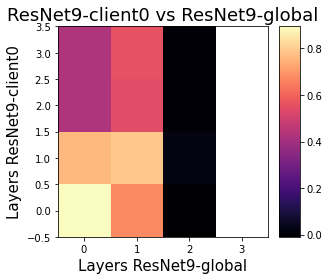

In [22]:
cka.plot_results()

In [15]:
results = cka.export()  # returns a dict that contains model names, layer names
                        # and the CKA matrix
results

{'model1_name': 'ResNet9-client0',
 'model2_name': 'ResNet9-global',
 'CKA': tensor([[ 0.0006,  0.0397,     nan,     nan],
         [-0.0025,  0.0162,     nan,     nan],
         [-0.0021,  0.0132,     nan,     nan],
         [-0.0022,  0.0121,     nan,     nan]]),
 'model1_layers': ['prep', 'layer1', 'layer2', 'layer3'],
 'model2_layers': ['prep', 'layer1', 'layer2', 'layer3'],
 'dataset1_name': '<data.datasets.CIFAR10_truncated object at 0x7f72c029f580>',
 'dataset2_name': '<data.datasets.CIFAR10_truncated object at 0x7f72c029f580>'}

In [41]:
# For partition check

# _, y_train, _,_ = load_cifar10_data('~/data')
# net_cls_counts = {}
# for net_i, dataidx in net_dataidx_map.items():
#     unq, unq_cnt = np.unique(y_train[dataidx], return_counts=True)
#     net_cls_counts[net_i] = {unq[i]: unq_cnt[i] for i in range(len(unq))}
# net_cls_counts

In [ ]:
net_dataidx_map = get_partition_dict(
    'cifar10', 'noniid-labeldir', 10, datadir='~/data', init_seed=0,
    beta=0.5
)